In [1]:
import astropy
from astropy.io import fits 
from astropy.time import Time
from astropy.visualization import time_support
from astropy.timeseries import LombScargle
from astropy.convolution import Box1DKernel
from astropy.convolution import convolve
import matplotlib.pyplot as plt
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import numpy as np
import numpy.ma as ma
import os
import pandas as pd
import scipy.signal as sig
from astropy.stats import sigma_clip
import warnings
import time 
import itertools

In [2]:
from functools import partial

import matplotlib as mpl
from scipy import signal, stats
from scipy.ndimage import center_of_mass

# install moonbow first. in repo root:
# pip install -e . --no-deps
from moonbow.fit import Fit

rng = np.random.default_rng()

In [3]:
def dataClean(filename): 
    
    """ This function removes nan values and corrects time values for TESS 20 second cadence data. 
        Also corrects TESS flux to energy in ergs."""
    
    #Create an array of time and flux data with nans removed    
    with fits.open(filename, mode="readonly",ignore_missing_simple=True) as hdulist:
        raw_time = hdulist[1].data['TIME']
        raw_flux = hdulist[1].data['PDCSAP_FLUX']
        raw_err = hdulist[1].data['PDCSAP_FLUX_ERR']
        ontime = hdulist[1].header['LIVETIME']
        ra = hdulist[0].header['RA_OBJ']
        dec = hdulist[0].header['DEC_OBJ']
    data = np.vstack((raw_time, raw_flux, raw_err))
    nonan_data = data[:, ~np.isnan(data).any(axis=0)]

    times = nonan_data[0]
    flux = nonan_data[1]
    error = nonan_data[2]
    
    #Create Dataframe of cleaned data
    time = np.array(times)
    flux = np.array(flux)
    err = np.array(error)
   
    skypos = (ra,dec)

    #Convert energy to ergs
    #dist_cm = distance_pc * 3.086e+18
    #ergs = []
    #ergs_err = []
    
    #for i in flux: 
    #    fluence = i * eff_width
    #    energy = (4 * np.pi * (dist_cm**2) * fluence)
    #    ergs.append(energy*1.95829e-9) #AB system zero point
        
    #for i in err:
    #    fluence_err = i*eff_width
    #    energy_err = (4 * np.pi * (dist_cm**2) * fluence_err)
    #    ergs_err.append(energy_err*1.95829e-9) #AB system zero point
        
    #energy = np.asarray(ergs)
    #error = np.asarray(ergs_err)

    
    #Return cleaned data
    return pd.DataFrame({
                        'Time': time,                        
                        #'Energy': energy,
                        #'Energy Error': error,
                        'Flux': flux,
                        'Flux Error': err
    }),ontime, ra, dec


In [4]:
#Using only until large flare function is completed, need more stars to get a better idea for a good
#model for stellar quiescence generation

def generate_Qcurve(clean_dataframe):
    """ This function takes cleaned data to create a dataframe of the estimated quiescent light curve"""

    q_time = clean_dataframe['Time'] # time associated w/ quiescent flux
    
    #Set and index variables
    fluxes = clean_dataframe['Flux']
    times = clean_dataframe['Time']
    F_err = clean_dataframe['Flux Error'] 

    #Smooth
    smooth_1 = sig.savgol_filter(fluxes,1400,3)
    q_flux = sig.savgol_filter(smooth_1,2000,3)
    
    #Create/return dataframe
    
    return pd.DataFrame({
                'Time': q_time,
                'Quiescent Flux':q_flux
    })

In [5]:
#box smooth
def box_smooth(flaring_frame):
    kernel = Box1DKernel(20)
    flux = flaring_frame['Flux']
    smooth_flux = convolve(flux,kernel, boundary='extend')
    q_frame = pd.DataFrame({
                            'Time':flaring_frame['Time'].values,
                            'Quiescent Flux': smooth_flux
        
    })
    return q_frame

In [6]:
def find_ix_ranges(ix, buffer=False):
    """ Finds indexes in the range.
    
        From MC GALEX function defs"""
    
    foo, bar = [], []
    for n, i in enumerate(ix):
        if len(bar) == 0 or bar[-1] == i-1:
            bar += [i]
        else:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
            bar = [i]
        if n == len(ix)-1:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
    return foo

In [7]:
def get_inff(lc, clipsigma=3, quiet=True, band='NUV',
             binsize=20.):
    """ Calculates the Instantaneous Non-Flare Flux values.
    
        From MC GALEX function defs"""
    
    sclip = sigma_clip(np.array(lc['Flux']), sigma=clipsigma)
    inff = np.ma.median(sclip)
    inff_err = np.sqrt(inff*len(sclip)*binsize)/(len(sclip)*binsize)
    if inff and not quiet:
        print('Quiescent at {m} AB mag.'.format(m=gt.counts2mag(inff, band)))
    return inff, inff_err


In [8]:

def find_flare_ranges(curve,q_curve,sig,quiescence=None):
    """This function will run through the data to find 
    flares and ranges of flares. This function will return
    a table of flares ranges. 
    
    Adapted from MC GALEX function defs.
    Stage: complete"""
    
    tranges = [[min(curve['Time']), max(curve['Time'])]] 
    if not quiescence:
        q, q_err = get_inff(curve)
    else:
        q, q_err = quiescence
    flare_ranges = []
    for trange in tranges:
        ix = np.where(((np.array(curve['Flux'].values)-(sig*np.array(curve['Flux Error'].values)) >= q_curve['Quiescent Flux'])))[0]
        flareFlux = ix
        if not len(ix):
            continue
        flux_ix = []
        
        for ix_range in find_ix_ranges(ix):
            # go backwards
            consec = 0 
            err = curve.iloc[ix_range[0]]['Flux Error'] 
            
            #while flux - err > quiescence, find 2 consecutive points within quiescent curve
            while (curve.iloc[ix_range[0]]['Flux']-err >= q_curve.iloc[ix_range[0]]['Quiescent Flux']) and ix_range[0] > 0 or (consec < 1 and ix_range[0] >0):
                err = curve.iloc[ix_range[0]]['Flux Error']

                if curve.iloc[ix_range[0]]['Flux']- err < q_curve.iloc[ix_range[0]]['Quiescent Flux']:
                    consec +=1
                else: 
                    consec = 0
                if (curve.iloc[ix_range[0]+1]['Time']-curve.iloc[ix_range[0]]['Time']) > 1000: 
                    break               
                ix_range = [ix_range[0] - 1] + ix_range
                
                # go forwards
            consec = 0 
            err = curve.iloc[ix_range[-1]]['Flux Error']
            while(curve.iloc[ix_range[-1]]['Flux'] - err >= q_curve.iloc[ix_range[-1]]['Quiescent Flux']) and ix_range[-1] != len(curve)-1 or (consec <1 and ix_range[:-1]!= len(curve)-1):
                err = curve.iloc[ix_range[-1]]['Flux Error']
                if curve.iloc[ix_range[-1]]['Flux']-err < q_curve.iloc[ix_range[-1]]['Quiescent Flux']:
                    consec += 1
                else: 
                    consec = 0
                if curve.iloc[ix_range[0]]['Time']-curve.iloc[ix_range[-1]]['Time'] > 1000: 
                    break
                ix_range = ix_range + [ix_range[-1] + 1]
                
            flux_ix += ix_range
        ix = np.unique(flux_ix)
        flare_ranges += find_ix_ranges(list(np.array(ix).flatten()))
    return(flare_ranges,flareFlux)

In [9]:
def refine_flare_ranges(curve,q_curve, sig=3., flare_ranges=None):
    """ Identify the start and stop indexes of a flare event after
    refining the INFF by masking out the initial flare detection indexes. 
    From MC GALEX function defs."""
    time_support()
    if not flare_ranges:
        flare_ranges, _ = find_flare_ranges(curve, q_curve, sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    quiescience_mask = [False if i in flare_ix else True for i in
                        np.arange(len(curve['Time']))]
    quiescence = q_curve
    quiescence_err = (np.sqrt(curve['Flux'][quiescience_mask].sum())/curve['Flux'].sum())
    flare_ranges, flare_3sigs = find_flare_ranges(curve,q_curve,
                                                  quiescence=(quiescence,
                                                              quiescence_err),
                                                  sig=sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    not_flare_ix = list(set([x for x in range(len(curve['Time']))]) - set(flare_ix))
      
    return flare_ranges, flare_ix

In [10]:
def qpp_find(flaring_frame,ranges_ix,energy_ix):
    
    ranges = []
    for i,v in enumerate(ranges_ix):
        t = flaring_frame['Time'][v]
        f = flaring_frame['Flux'][v]
        ranges.append([i,t,f])

        #Select Large Flares

    large_flares = []
    for i,v in enumerate(ranges_ix):
        if len(v)>12:                    #~4 minute minimum for davenport flare model                
            large_flares.append((v))
        else:
            continue

#Match Data to Large Flares

    large_flare_data = []
    for i,v in enumerate(large_flares):
        data = flaring_frame['Flux'][large_flares[i]]
        large_flare_data.append(data)
    
    norm_flares=[] #normalize flare values
    for i in range(len(large_flare_data)):
        mx = max(large_flare_data[i])
        norm_flares.append(large_flare_data[i]/mx)
    
    times=[]
    for i in range(len(large_flares)):
        t = flaring_frame['Time'][large_flare_data[i].index]
        times.append(t)
        
    lg_flare_data=[]
    lg_flare_time=[]
    lg_flare_det=[]
    lg_flare_params = []
    flare_fits = []
    for i in range(len(large_flares)):
        model = aflare2
        x = flaring_frame['Time'][large_flares[i]]
        y = norm_flares[i]
        data = pd.DataFrame({'time': x, 'energy': y})
    
        rise = x[0:np.argmax(y)].values
        fwhm = (max(rise)-min(rise))*2
    
        fitter = Fit(
        underlying_function=model,
        dimensionality=1,
        data=data,
        dependent_variable='energy')
    
        fitter.make_vector(independent_variables=['time'])
        fitter.fit(guess=np.array((max(rise),fwhm,1,
                              1.00000, 1.94053, -0.175084, -2.3769, -1.12498,
                              0.689008, -1.600536, 0.302963, -0.278318))) 
        if fitter.det > 0.60:
            lg_flare_time.append(x.values)
            lg_flare_data.append(y.values)
            lg_flare_det.append(fitter.det)
            fit_params, covariance_matrix = fitter.curve_fit
            lg_flare_params.append((fit_params))
            fit = fitter.fitted_curve 
            flare_fits.append((fit))
    return lg_flare_data, lg_flare_time, lg_flare_det, lg_flare_params, flare_fits


In [11]:
def fit_flares(flaring_frame,flare_ranges):
  
    ranges = []
    for i,v in enumerate(flare_ranges[0]):
        t = flaring_frame['Time'][v]
        f = flaring_frame['Flux'][v]
        ranges.append([i,t,f])

    flares = []
    for i,v in enumerate(flare_ranges[0]):
        flares.append((v))

    flare_data = []
    for i,v in enumerate(flares):
        data = flaring_frame['Flux'][flares[i]]
        flare_data.append(data)
    
    
    #norm_flares=[] #normalize flare values
    #for i in range(len(flare_data)):
        #mx = max(flare_data[i])
        #norm_flares.append(flare_data[i]/mx)
    norm_flares =(flare_data-np.min(flare_data))/(np.max(flare_data)-np.min(flare_data))   
    times=[]
    for i in range(len(flares)):
        t = flaring_frame['Time'][flare_data[i].index]
        times.append(t)
    
    fit_determinant = []
    flare_fit_parameters = []
    flare_fits = []
    for i in range(len(flare_ranges[0])):
        try:
            if len(flare_ranges[0][i])>12:
                model = aflare2
                x = flaring_frame['Time'][flare_ranges[0][i]]
                y = norm_flares[i]
                data = pd.DataFrame({'time': x, 'energy': y})
    
                rise = x[0:np.argmax(y)].values
                fwhm = (max(rise)-min(rise))*2
    
                fitter = Fit(
                underlying_function=model,
                dimensionality=1,
                data=data,
                dependent_variable='energy')
    
                fitter.make_vector(independent_variables=['time'])
                fitter.fit(guess=np.array((max(rise),fwhm,1,
                                  1.00000, 1.94053, -0.175084, -2.3769, -1.12498,
                                  0.689008, -1.600536, 0.302963, -0.278318))) 
        
                fit_determinant.append(fitter.det)
                fit_params, covariance_matrix = fitter.curve_fit
                flare_fit_parameters.append((fit_params))
                fit = fitter.fitted_curve 
                flare_fits.append((fit))
            else:
                fit_determinant.append(str("-"))
                flare_fit_parameters.append(str("-"))
                flare_fits.append(str("-"))
        except:
            fit_determinant.append(str('-'))
            flare_fit_parameters.append(str("-"))
            flare_fits.append(str("-"))
                   
    return fit_determinant, flare_fit_parameters, flare_fits


In [12]:
def fit_residuals(lg_flare_data,flare_fits):
    residuals = []
    for i in range(len(lg_flare_data)):
        res_i = lg_flare_data[i]-flare_fits[i]
        residuals.append((res_i))

    kernel = Box1DKernel(8)
    res_fits = []
    for i in range(len(residuals)):
        res_fit = sig.savgol_filter(residuals[i],21,3)
        fit2 = convolve(res_fit,kernel,boundary='extend')
        res_fits.append(fit2)
    
    return(residuals, res_fits)

In [13]:
def energyCalculation2(flaring_frame,q_frame,flare_ranges,dist_pc,binsize=20):
    """This function will calculate the energies of each flare.
        Stage: complete"""

    distance_cm = dist_pc*3.086e+18
    eff_width = 3.898e-5 
    flare_flux = flaring_frame['Flux'][flare_ranges[1]]-q_frame['Quiescent Flux'][flare_ranges[1]]
    flare_flux_error = flaring_frame['Flux Error'][flare_ranges[1]]
    
    
    energy_error=[]
    energies=[]
    flare_flux[flare_flux<0]=0
    
    for i,v in enumerate(flare_ranges[0]):
        integrated_flux = (flare_flux[v]*binsize).sum()
        fluence_error = np.sqrt(((flare_flux_error[v]*binsize)**2).sum())*eff_width
        fluence = integrated_flux*eff_width
        energy = (4 * np.pi * (distance_cm**2) * fluence)
        energy_err = (4 * np.pi * (distance_cm**2) * fluence_error)
        energy_error.append(energy_err*1.95829e-9 )
        energies.append(energy*1.95829e-9) 
        
    #Using AB system zero point (1.95829e-9 erg/cm2/s/A) from 
    #http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=TESS/TESS.Red&&mode=browse&gname=TESS&gname2=TESS
    
    return(energies,energy_error)

In [14]:
def FlareTable(flaring_frame,flare_ranges,flare_total_energies,det,params):
    """This function will build a table of all flares.
        Stage: complete"""
    
    #Generate quiescent and flaring curves in order to index time values
    times = flaring_frame['Time']
    
    #Create empty lists to use as columns for table

    tstart = []
    tstop = []
    duration = []
    energy = flare_total_energies[0]
    energy_error = flare_total_energies[1]
    
    #Populate Lists
    for flare in flare_ranges[0]:
        start_ix = times[flare[0]]
        stop_ix = times[flare[-1]]
        tstart.append(start_ix)
        tstop.append(stop_ix)
        duration.append(((times[flare[-1]]-times[flare[0]])))


        
    #Build flare table
    flareTable = pd.DataFrame({
                                "Start Time": tstart,
                                "Stop Time": tstop,
                                "Duration (BTJD)": duration,
                                "Total Energy": energy,
                                "Energy Error": energy_error,
                                "Fit Determinant": det,
                                "Fit Parameters": params
    })
    
    return(flareTable)

In [15]:
def aflare2(t, tpeak, fwhm, ampl,
            c0,c1,c2,c3,c4,
            d0,d1,d2,d3):
#    t : 1-d array
#        The time array to evaluate the flare over
#    tpeak : float
#        The time of the flare peak
#    fwhm : float
#        The "Full Width at Half Maximum", timescale of the flare
#   ampl : float
#        The amplitude of the flare
#    Returns
#    flare : 1-d array
#        The flux of the flare model evaluated at each time
    #_fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fr = [c0,c1,c2,c3,c4]
    #_fd = [0.689008, -1.60053, 0.302963, -0.278318]
    _fd = [d0,d1,d2,d3]
    
    t = np.array(t)
    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

In [17]:
def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg

### Open Target Table

In [18]:
target_table=pd.read_csv('/Users/katborski/Documents/GitHub/QPPs/moonbow-main/moonbow/target_table_v4.csv')
#target_table.to_csv('target_table_v4.csv')
target_table


Unnamed: 0         ID         RA        DEC       Distance (pc)   
0             0  194140883   0.799390  40.874429   212.9437068379279  \
1             1  257468888   0.178464   1.539418   66.52028268588535   
2             2  378587653   0.787423  71.666174   1106.187032007378   
3             3  405266556   0.278040  11.010090   619.2184950791286   
4             4  405266970   0.671196  10.906756   352.2410709682985   
..          ...        ...        ...        ...                 ...   
228         228  371424444  43.098459  19.135403   390.3499964019931   
229         229  387514723  43.212127   8.610317  169.36059039021782   
230         230  436884337  43.060654  28.625115   194.1325218627535   
231         231   91482401  44.798077  21.978623   162.5624604878131   
232         232  346671840  44.956023  34.639586  205.06886008931363   

     Simbad Match Offset  Gaia Match Offset Gaia Parallax-Over-Error   
0               0.003855           0.592679                253.72153  \
1               0.005839           1.144232                273.42426   
2               0.003576           0.039100                 41.05097   
3               0.005630           0.198022                 45.85235   
4               0.001907           0.847877                141.26736   
..                   ...                ...                      ...   
228             0.000859           0.234056                117.64143   
229             0.003044           0.195548                186.93867   
230             0.001506           0.881475                 29.91068   
231             0.001510           0.432161                58.794544   
232             0.002152           0.283468                177.24597   

    Spectral Type  
0              K4  
1           K4/5V  
2           K1III  
3              K0  
4              K3  
..            ...  
228         M6.5V  
229         K1III  
230            K5  
231            M4  
232            K0  

[233 rows x 9 columns]

### Convert the following cells to code to build flare_stat_table

In [128]:
path = '/Users/katborski/Documents/GitHub/QPPs/moonbow-main/fast_lc_files/'


In [129]:
### open data & create list of datafiles
event_files = []
for visit in os.listdir(path):
    vis_path = path+visit
    event_files+=[vis_path]

In [130]:
### Functions for matching data from target table to event files
def match_id_to_spectraltype(filename,target_table):
    
    """ Matches distances in target table to TICID in event files"""
    
    with fits.open(filename, mode="readonly",ignore_missing_simple=True) as hdulist:
        ticid = hdulist[0].header['TICID']
    
    loc = target_table.loc[target_table['ID']==ticid]
    ix = loc.index
    st = target_table['Spectral Type'][ix].values
    
    return np.ndarray.tolist(st)

In [131]:
def match_id_to_distance(filename,target_table):
    
    """ Matches distances in target table to TICID in event files"""
    
    with fits.open(filename, mode="readonly",ignore_missing_simple=True) as hdulist:
        ticid = hdulist[0].header['TICID']
    
    loc = target_table.loc[target_table['ID']==ticid]
    ix = loc.index
    dist = target_table['Distance (pc)'][ix].values
        
    return dist, float(ticid)


### Retrieves largest flare from each target

In [ ]:

lg_flr_flux = []
lg_flr_time = []
lg_flr_er = []
for i in range(len(event_files)):
    try:

        flaring_frame, ontime, ra, dec = dataClean(event_files[i])
        
        q_frame = generate_Qcurve(flaring_frame)
        
        dist, ticid = match_id_to_distance(event_files[i],target_table)
        
        #st = match_id_to_spectraltype(event_files[i],target_table)
            
        
        ranges,flux = find_flare_ranges(flaring_frame,q_frame,3,quiescence=None) 
        flare_ranges = refine_flare_ranges(flaring_frame,q_frame,3)
            ### flare_ranges contains 2 elements: 
            ###    [0] = flare_ranges,
            ###    [1] = flare_flux
        
        flare_total_energies = energyCalculation2(flaring_frame,q_frame,flare_ranges,float(dist),binsize=20)
            ### flare_total_energies has 2 elements: 
            ###     [0] = integrated energy
            ###     [1] = integrated energy error
        lens=[]
        for j in range(len(flare_ranges[0])):
            lens.append(len(flare_ranges[0][j]))
        ix = lens.index(max(lens))
        ixs = flare_ranges[0][ix]

        lg_flr_flux.append([flaring_frame['Flux'][ixs]])
        lg_flr_time.append([flaring_frame['Time'][ixs]])
        lg_flr_er.append([flaring_frame['Flux Error'][ixs]])
        
        
        print(i)
    except:
        print(str('fail'),i)
        

### Algorithm to add more time before/after flares

for i in range(len(flare_ranges[0])):
    s = flare_ranges[0][i][0]
    e = flare_ranges[0][i][-1]
    ranges = flare_ranges[0][i]
    
    ranges.insert(0,s-1)
    ranges.insert(0,s-2)
    ranges.insert(0,s-3)
    ranges.insert(0,s-4)
    ranges.insert(0,s-5)
    ranges.insert(0,s-6)
    ranges.insert(0,s-7)
    ranges.insert(0,s-8)
    ranges.insert(0,s-9)
    ranges.insert(0,s-10)
    ranges.insert(0,s-11)
    ranges.insert(0,s-12)

    x = len(ranges)
    ranges.insert(x,e+1)
    ranges.insert(x+1,e+2)
    ranges.insert(x+2,e+3)
    ranges.insert(x+3,e+4)
    ranges.insert(x+4,e+5)
    ranges.insert(x+5,e+6)
    ranges.insert(x+5,e+7)
    ranges.insert(x+5,e+8)
    ranges.insert(x+5,e+9)
    ranges.insert(x+5,e+10)
    ranges.insert(x+5,e+11)
    ranges.insert(x+5,e+12)

## Make Plots of Largest Detected Flares 

In [185]:
import itertools
new = []
new_er = []
new_time = []
for i in range(len(lg_flr_flux)):
    for j in lg_flr_flux[i]:
        f = j.values
        new.append(f)
for i in range(len(lg_flr_er)):
    for j in lg_flr_er[i]:
        f = j.values
        new_er.append(f)
for i in range(len(lg_flr_time)):
    for j in lg_flr_time[i]:
        f = j.values
        new_time.append(f)

In [186]:
norm_flux = []
for i in range(len(new)):
    to_norm = new[i]
    norm = (to_norm-np.min(to_norm))/(np.max(to_norm)-np.min(to_norm))
    norm_flux.append(norm)
norm_er = []
for i in range(len(new_er)):
    to_norm = new_er[i]
    norm = (to_norm-np.min(to_norm))/(np.max(new[i])-np.min(new[i]))
    norm_er.append(norm)

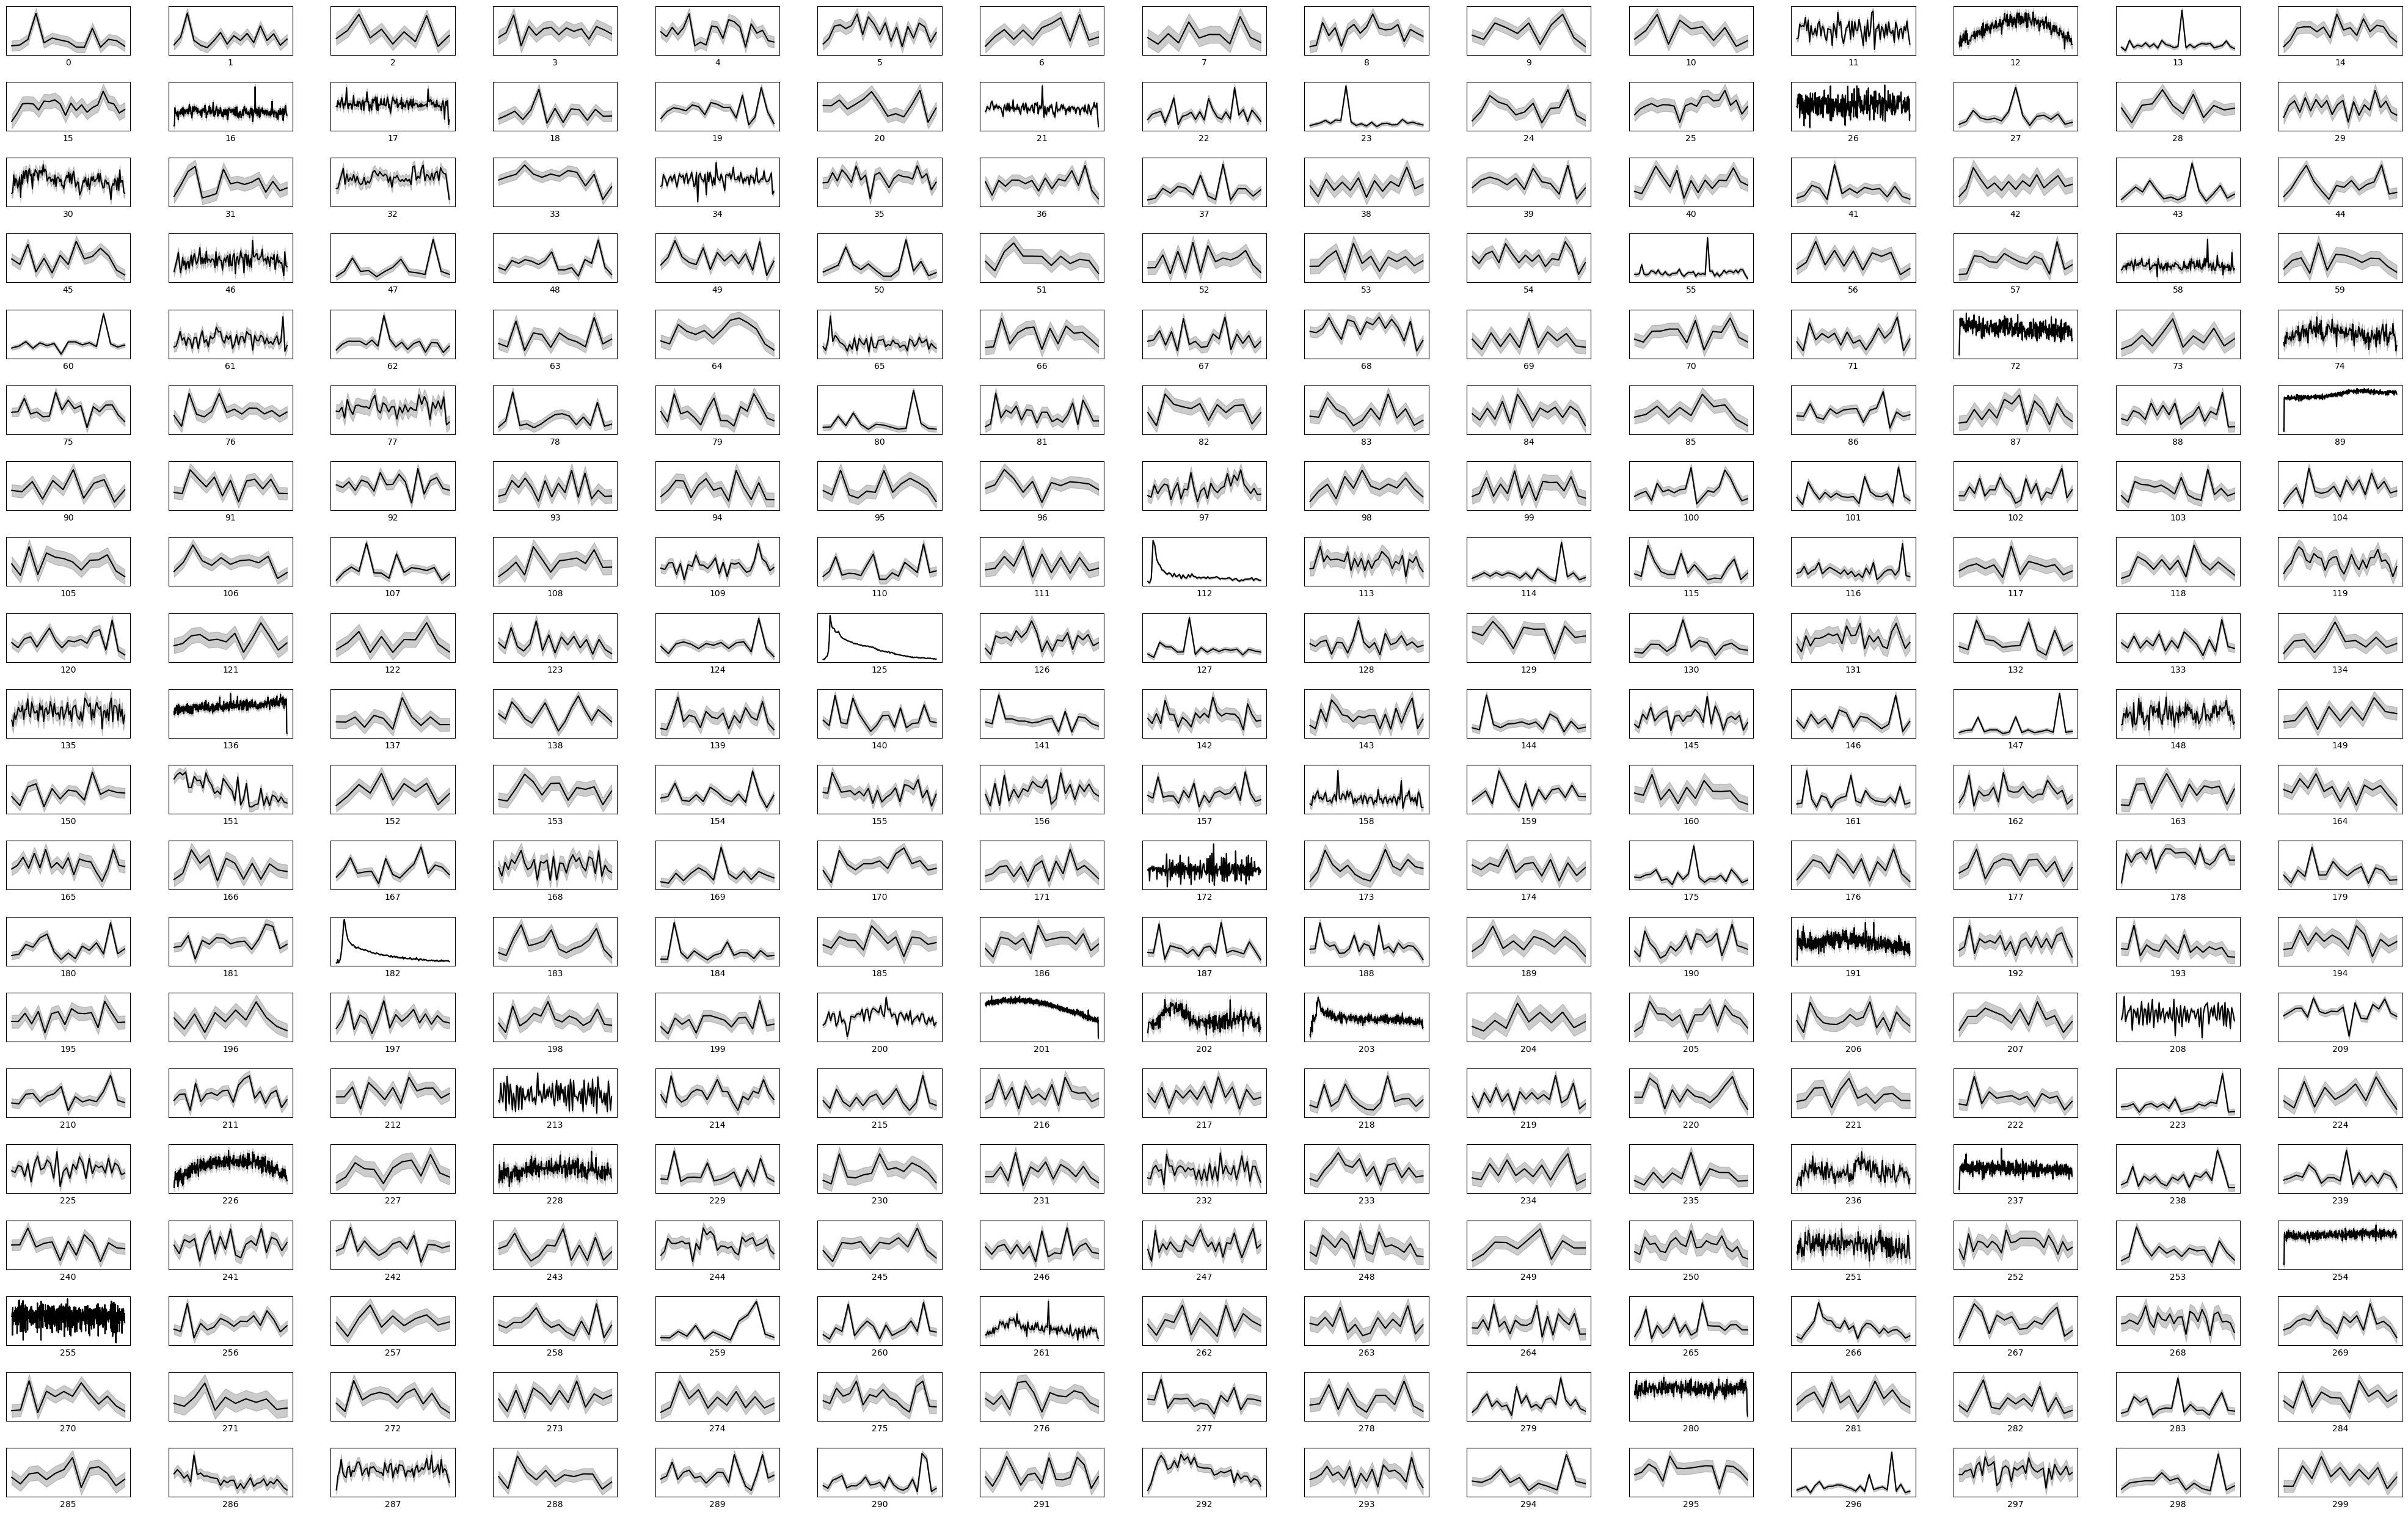

In [137]:
fig,ax = plt.subplots(20,15)
fig.set_size_inches(40,25)
fig.tight_layout()
for i in range(len(new)):
    ##ENUMERATE

    ax.flat[i].plot(new[i],color='black')
    ax.flat[i].fill_between(range(len(new[i])),new[i]+new_er[i],new[i]-new_er[i],alpha=0.4,color='grey')
    ax.flat[i].set_xlabel(i)
    plt.setp(ax, xticks=[], yticks=[])
   # plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()
#fig.savefig('large_flares_errorbars_v1',dpi=300, bbox_inches="tight", pad_inches=0)

In [251]:
ne = []
for i in range(len(new)):
    v = new[i]+new_er


array([0.00258835, 0.0025895 , 0.00257551, 0.00258103, 0.00258287,
       0.00258021, 0.00258076, 0.00256928, 0.00258437, 0.00258815,
       0.00258293, 0.00258256, 0.00257868, 0.002569  , 0.00258512,
       0.00259304])

In [252]:
norrm = []
for i in range(len(ratios)):
    norm_er = np.abs(new_er[i])/(np.abs(new[i]))
    norrm.append(norm_er)

## Fit with Davenport Model or Box Fit

In [139]:
fitted_curves = []
cov_matrix = []
params = []
dets = []

for i in range(len(norm_flux)):
    if len(norm_flux[i])>=15:
        model = aflare2
        x = new_time[i]
        y = norm_flux[i]
        data = pd.DataFrame({'time': x, 'energy': y})
        
        rise = x[0:np.argmax(y)]#.values
        fwhm = (max(rise)-min(rise))*2
    
        fitter = Fit(
            underlying_function=model,
            dimensionality=1,
            data=data,
            dependent_variable='energy')
    
        fitter.make_vector(independent_variables=['time'])
        fitter.fit(guess=np.array((max(rise),fwhm,1,
                              1.00000, 1.94053, -0.175084, -2.24588, -1.12498,
                              0.689008, -1.60053, 0.302963, -0.278318))) 
    
        par, cov = fitter.curve_fit
        cov_matrix.append(cov)
        params.append(par)
    
        fit = fitter.fitted_curve
        fitted_curves.append(fit)
    
        det = fitter.det
        dets.append(det)
    else:
        kernel = Box1DKernel(3,mode='center')
        box_fit = convolve(norm_flux[i], kernel, boundary='extend')

        cov_matrix.append('n/a')
        params.append('n/a')
        dets.append(float(0))
        fitted_curves.append(box_fit)

/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_64754/2217213140.py:29: RuntimeWarning: overflow encountered in exp
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/Users/katborski/opt/anaconda3/envs/moonbow/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_64754/2217213140.py:28: RuntimeWarning: overflow encountered in exp
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_64754/2217213140.py:28: RuntimeWarning: invalid value encountered in add
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/var/folders/rk/8540q6zs19j7wbgwdq52jbv40000gn/T/ipykernel_64754/2217213140.py:29: RuntimeWarning: overflow encountered in multiply
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/var/folders/rk/8540q6zs19j7wbgw

In [283]:
ers = [] 
for i in range(len(new_er)):
    er = (new_er[i])/(np.max(new[i])-np.min(new[i]))
    ers.append(er)
ers


[array([0.15340781, 0.1534213 , 0.15347082, 0.15375838, 0.15344998,
        0.1534425 , 0.15344194, 0.15344064, 0.15334899, 0.15337825,
        0.15356882, 0.15337723, 0.15346347, 0.1534295 , 0.15338971]),
 array([0.14147965, 0.14159143, 0.14360524, 0.14150373, 0.1414515 ,
        0.14144712, 0.14160397, 0.1416762 , 0.14149911, 0.14158868,
        0.14155405, 0.14161064, 0.14145806, 0.14169625, 0.1414952 ,
        0.14156572, 0.14146546, 0.14159573]),
 array([0.19397713, 0.20668487, 0.19586554, 0.19347584, 0.19429604,
        0.19295082, 0.19431062, 0.19306554, 0.19551723, 0.19300501,
        0.19356789]),
 array([0.22164405, 0.22153234, 0.22318414, 0.22119311, 0.22180722,
        0.2221568 , 0.22224757, 0.2215503 , 0.2218381 , 0.22122473,
        0.22195816, 0.22117696, 0.22040453, 0.23194849, 0.22219965,
        0.22901796]),
 array([0.17001309, 0.16990561, 0.1700902 , 0.16985478, 0.17003354,
        0.1708297 , 0.16972989, 0.16984096, 0.1697168 , 0.17154427,
        0.16996998, 0.16

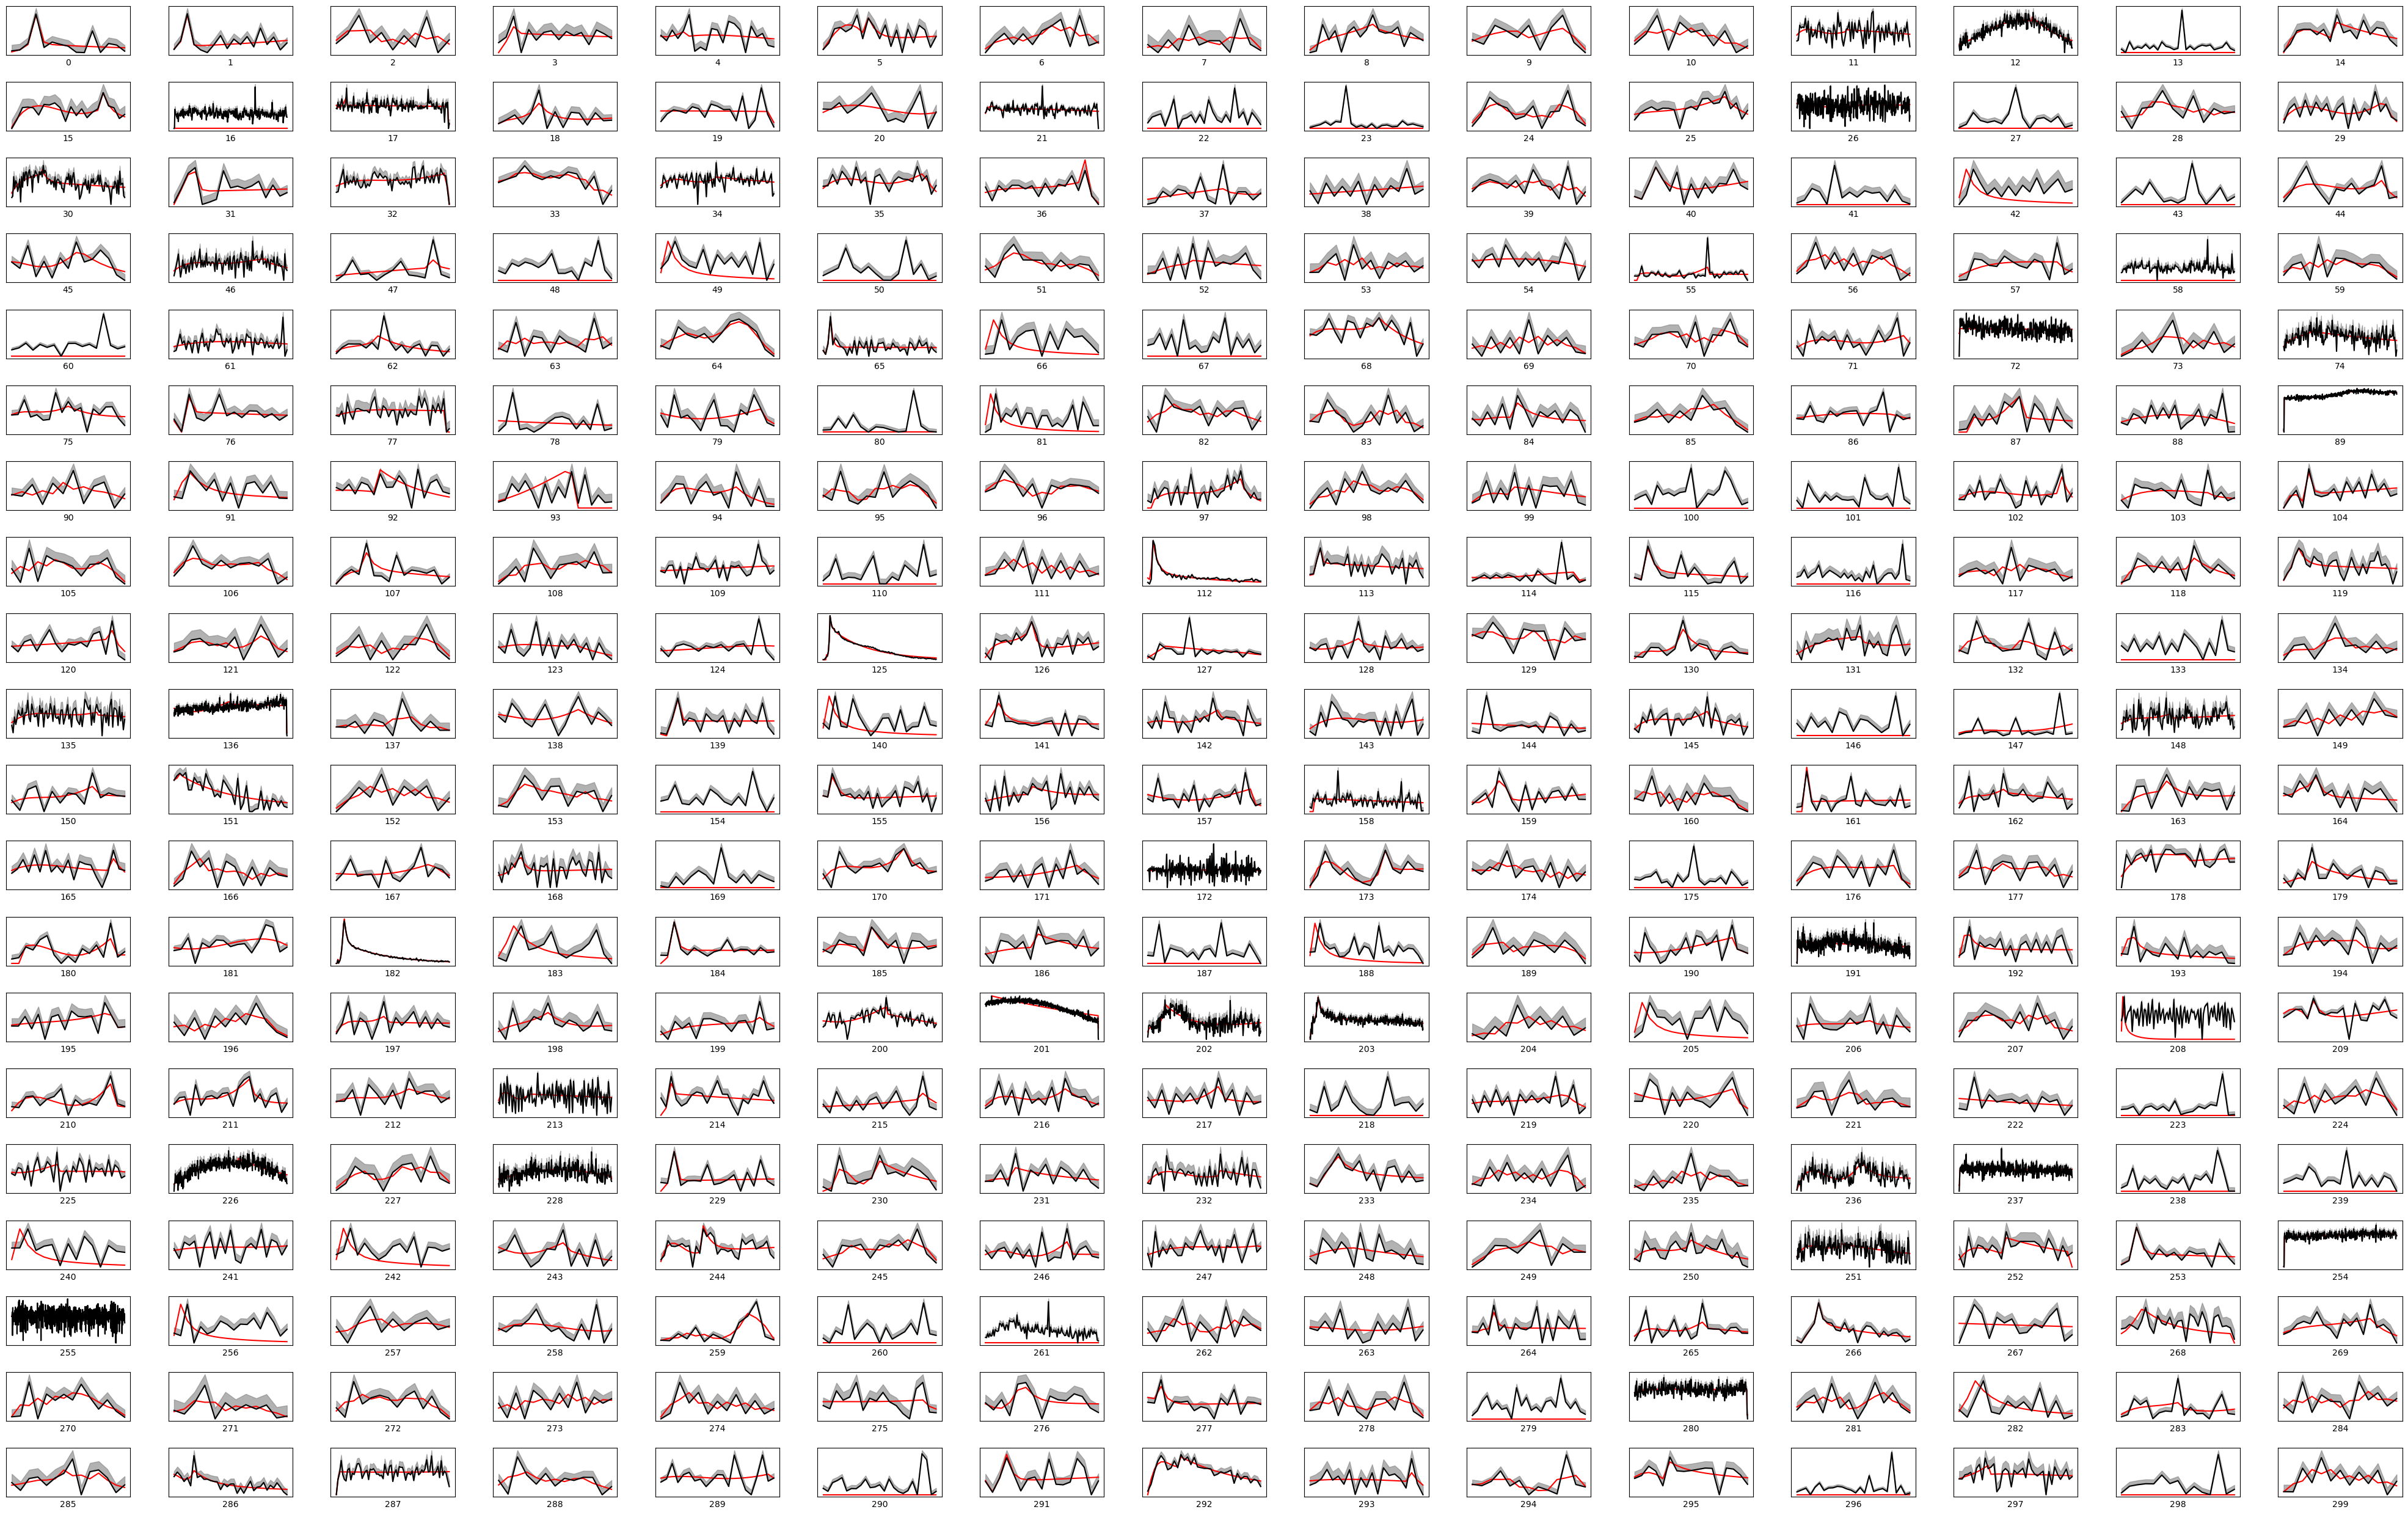

In [285]:
fig,ax = plt.subplots(20,15)
fig.set_size_inches(40,25)
fig.tight_layout()
for i in range(len(norm_flux)):
    curve = norm_flux[i]
    fit = fitted_curves[i]
    er = ers[i]
    ax.flat[i].fill_between(range(len(curve)),curve,curve+er,curve-er,color='grey',alpha=0.6)
    ax.flat[i].plot(fit,color='red')
    ax.flat[i].plot(curve,color='black')
    ax.flat[i].set_xlabel(i)
    plt.setp(ax, xticks=[], yticks=[])
    #plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

In [286]:
#fig.savefig('flares_w_fits_v4',dpi=300, bbox_inches="tight", pad_inches=0)

In [378]:
param_table = pd.DataFrame({
                            'Target No.':ids,
                            'Fit Determinant': dets,
                            #'Fit Parameters': params,
                            #'Covariance Matrix': cov_matrices
})

In [390]:
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: palegreen' if is_max.any() else '' for v in is_max]

In [395]:
good_det_ix =[i for i,v in enumerate(dets) if v >= 0.7]

In [391]:
param_table.style.apply(highlight_greaterthan, threshold=0.699, column=['Fit Determinant'], axis=1)


In [392]:
param_table
#param_table.to_csv('fit_determinants_v2.csv')

In [396]:
good_det_ix

[0, 12, 89, 112, 125, 173, 182, 184, 201, 203, 266, 292]

## Create some graphs

In [364]:
def get_id(filename):
    
    """ Matches distances in target table to TICID in event files"""
    
    with fits.open(filename, mode="readonly",ignore_missing_simple=True) as hdulist:
        ticid = hdulist[0].header['TICID']

    
    return ticid

In [377]:
ids = []
for i in range(len(event_files)):
    p = get_id(event_files[i])
    ids.append(p)

In [109]:
masses=[]
radii = []
r_flrs = []
flrs=[]
for i in range(len(df['Mass (M_sun)'])):
    if is_number(df['Mass (M_sun)'][i]) == True: 
        masses.append(float(df['Mass (M_sun)'][i]))
        flrs.append(df['Number of Flares'][i])
    else:
        continue
for i in range(len(df['Radius (R_sun)'])):
    if is_number(df['Radius (R_sun)'][i]) == True: 
        radii.append(float(df['Radius (R_sun)'][i]))
        r_flrs.append(df['Number of Flares'][i])
    else:
        continue

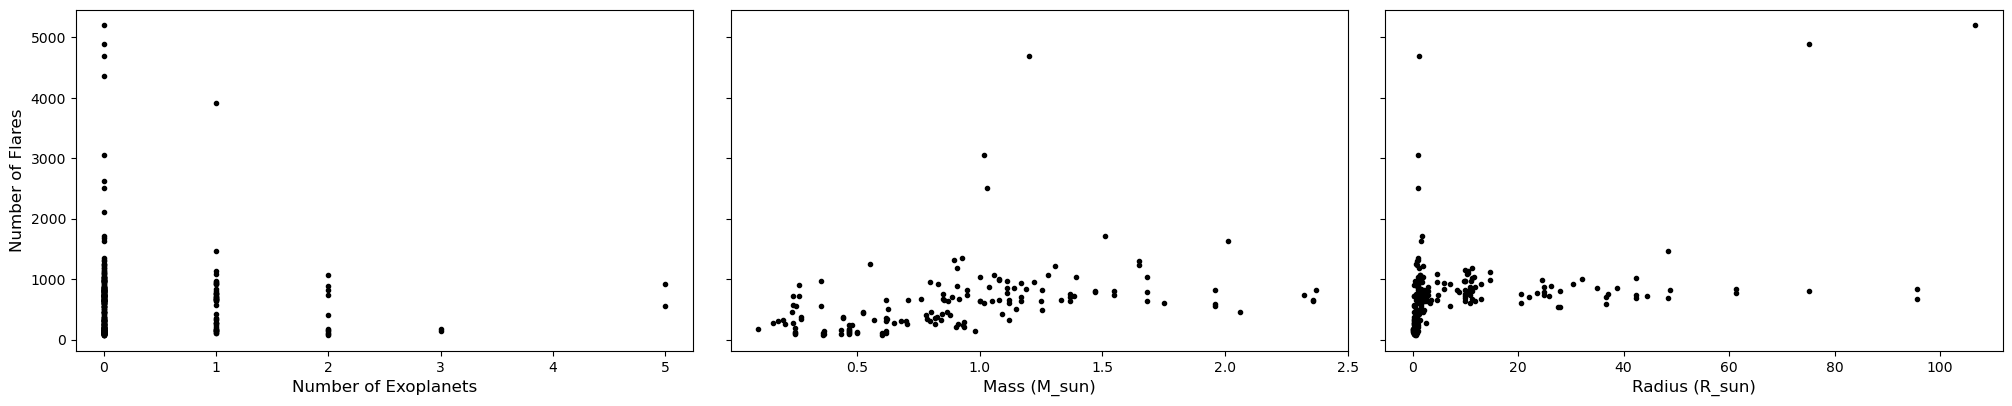

In [155]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey=True,figsize=(20,4))


fig.tight_layout()
ax1.scatter(exos,flares, marker='.', color='black')
ax1.set_xlabel('Number of Exoplanets',size='large')
ax1.set_ylabel('Number of Flares',size='large')
ax2.scatter(masses,flrs, marker='.', color='black')
ax2.set_xticks(ticks=(0.5,1,1.5,2,2.5))
ax2.set_xlabel('Mass (M_sun)',size = 'large')
ax3.scatter(radii,r_flrs, marker='.', color='black')
ax3.set_xlabel('Radius (R_sun)',size='large')
#fig.savefig('initial_graphs.png')

In [98]:
M_stars = []
n_flares_M = []
K_stars = []
n_flares_K = []
for i in range(len(df['Spectral Type'])):
    if df['Spectral Type'][i].startswith('M'):
        M_stars.append(df['Spectral Type'][i])
        n_flares_M.append(df['Number of Flares'][i])
    else:
        K_stars.append(df['Spectral Type'][i])
        n_flares_K.append(df['Number of Flares'][i])

In [99]:
m_sort = []
for i in range(len(M_stars)):
    m_sort.append(M_stars[i])
k_sort = []
for i in range(len(K_stars)):
    k_sort.append(K_stars[i])

In [100]:
new_ix_k = np.argsort(k_sort)

In [101]:
new_ix_m = np.argsort(m_sort)

In [102]:
m_sort.sort()

In [103]:
k_sort.sort()

In [113]:
m_flares = []
for i in range(len(n_flares_M)):
    ix = new_ix_m[i]
    m_flares.append(n_flares_M[ix])
k_flares = []
for i in range(len(n_flares_K)):
    k_flares.append(n_flares_K[new_ix_k[i]])

In [114]:
len(m_flares)

59

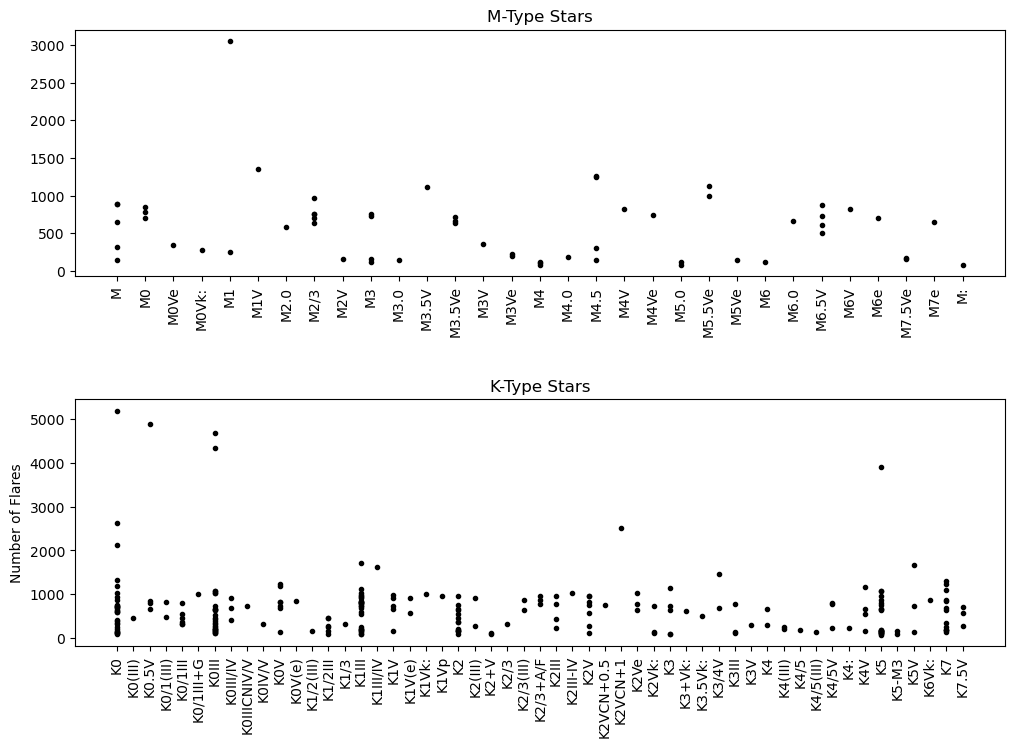

In [127]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(12,8))
fig.subplots_adjust(hspace=.5)

ax1.tick_params(axis='x',labelrotation=90)
ax2.tick_params(axis='x',labelrotation=90)
ax1.scatter(m_sort,m_flares,marker = '.',color='black')
ax2.scatter(k_sort,k_flares,marker = '.',color='black')
ax1.set_title('M-Type Stars')
ax2.set_title('K-Type Stars')
plt.ylabel('Number of Flares')
fig.savefig('M_v_K_flares.png',dpi=400)